In [1]:
import pandas as pd
from bs4 import BeautifulSoup

from bs4 import BeautifulSoup
import iexfinance
import matplotlib
import matplotlib.pyplot as plt
import re
import requests
import numpy as np
import pandas as pd

In [2]:
from selenium.webdriver.chrome.webdriver import WebDriver
import warnings

warnings.filterwarnings('ignore')

### https://blog.alpaca.markets/blog/2018/8/23/python-notebook-research-to-replicate-etf-using-freedata

# With an ETF symbol, get dataframe of what the ETF is holding

In [3]:
def get_table(soup):
    for t in soup.select('table'):
        header = t.select('thead tr th')
        if len(header) > 2:
            if (header[0].get_text().strip() == 'Symbol'
                and header[2].get_text().strip().startswith('% Holding')):
                return t
    raise Exception('could not find symbol list table')


def get_etf_holdings(etf_symbol):
    '''
    etf_symbol: str
    
    return: pd.DataFrame
    '''
    url = 'https://www.barchart.com/stocks/quotes/{}/constituents?page=all'.format(
        etf_symbol)

    # Loads the ETF constituents page and reads the holdings table
    browser = WebDriver() # webdriver.PhantomJS()
    browser.get(url)
    html = browser.page_source
    soup = BeautifulSoup(html, 'html')
    table = get_table(soup)

    # Reads the holdings table line by line and appends each asset to a
    # dictionary along with the holdings percentage
    asset_dict = {}
    for row in table.select('tr')[1:-1]:
        try:
            cells = row.select('td')
            # print(row)
            symbol = cells[0].get_text().strip()
            # print(symbol)
            name = cells[1].text.strip()
            celltext = cells[2].get_text().strip()
            percent = float(celltext.rstrip('%'))
            shares = int(cells[3].text.strip().replace(',', ''))
            if symbol != "" and percent != 0.0:
                asset_dict[symbol] = {
                    'name': name,
                    'percent': percent,
                    'shares': shares,
                }
        except BaseException as ex:
            print(ex)
    browser.quit()
    return pd.DataFrame(asset_dict)

In [4]:
spy = get_etf_holdings('SPY')

In [5]:
spy.T

,name,percent,shares
A,Agilent Technologies Inc.,0.09,3585629
AAL,American Airlines Group Inc.,0.07,4680837
AAP,Advance Auto Parts Inc.,0.05,831433
AAPL,Apple Inc.,4.36,55225348
ABBV,AbbVie Inc.,0.6,17029800
ABC,AmerisourceBergen Corporation,0.06,1845851
ABMD,ABIOMED Inc.,0.07,472125
ABT,Abbott Laboratories,0.48,19692944
ACN,Accenture Plc Class A,0.44,7221805
ADBE,Adobe Systems Incorporated,0.53,5531675


# IEX price data

In [6]:
def iex_charts(symbols):
    partlen = 99
    result = {}
    for i in range(0, len(symbols), partlen):
        charts = iexfinance.Stock(symbols[i:i+partlen]).get_chart(range='1m')
        if type(charts) == list:
            charts = {symbols[i]: charts}
        for symbol, data in charts.items():
            df = pd.DataFrame(data)
            df.date = pd.to_datetime(df.date)
            df.set_index('date', inplace=True)
            df.index.names = ['epoch']
            df.index = df.index.tz_localize('America/New_York')
            result[symbol] = df
    return result

def get_closes(constituents):
    symbols = list(constituents.columns)
    charts = iex_charts(symbols)
    return pd.DataFrame({symbol: df.close for symbol, df in charts.items()})

In [7]:
def simulate(etf_symbol, cash, weights):
    # weights = get_etf_holdings(etf_symbol)
    symbols = list(weights.keys())
    charts = iex_charts(symbols)
    initial_prices = pd.Series({symbol: df.open[0] for symbol, df in charts.items()})
    last_prices = pd.Series({symbol: df.close[-1] for symbol, df in charts.items()})

    
    # construct portfolio
    portfolio = pd.DataFrame({
        'weight': weights,
        'initial_price': initial_prices,
        'last_price': last_prices,
    })
    portfolio.fillna(0)
    portfolio['shares'] = cash * portfolio.weight / 100 // portfolio.initial_price
    # calculate return for each symbol
    portfolio['return'] = (portfolio.last_price - portfolio.initial_price) * portfolio.shares
    
    return portfolio

# Putting together, replicate SPY itself

In [8]:
closes = get_closes(spy)

In [10]:
replicated_perf = ((closes - closes.iloc[0]) * spy.loc['shares']).sum(axis=1) / (closes.iloc[0] * spy.loc['shares']).sum()

In [11]:
etf = iex_charts(['SPY'])['SPY']
original_perf = (etf.close - etf.close[0]) / etf.close[0]

In [12]:
performance = pd.DataFrame({'replicated': replicated_perf, 'original': original_perf})

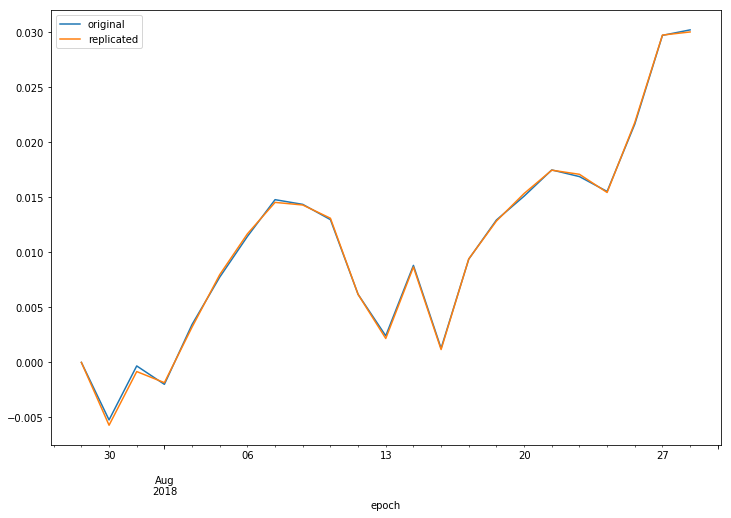

In [13]:
plt.figure(figsize=(12, 8))
performance.plot(figsize=(12, 8))